In [0]:
import numpy as np
import os
import csv
import re
from pprint import pprint
import time

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

!pip install sentence_transformers
# Git Clone of CRG
if "Customer-Review-Generation" not in os.listdir():
  !git clone https://github.com/maccuryj/Customer-Review-Generation.git
  !rm -rf src
  !rm -rf __pycache__
  !mv Customer-Review-Generation/src/* .
  !rm -rf Customer-Review-Generation/

import LSTMUtils
from LSTMUtils import *
from LSTMUtils import Model
from SetupData import SetupData
from ReviewLoader import ReviewDataset, ProductReviews, Embedder, Collator
from ReviewClustering import ReviewKMeans
from ReviewUtils import ReviewUtils, ReviewDataset
from ClusterEvaluation import ClusterEvaluation

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 573kB 13.2MB/s 
     |████████████████████████████████| 3.7MB 61.3MB/s 
     |████████████████████████████████| 890kB 54.8MB/s 
     |████████████████████████████████| 1.0MB 48.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.1-cp36-none-any.whl size=74031 sha256=a63b40a0707a4b05b02140ec7fcceefc3a1fd6fd42a0485457112d12998b795c
  Stored in directory: /root/.cache/pip/wheels/d7/fa/17/2b081a8cd8b0a86753fb0e9826b3cc19f0207062c0b2da7008
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=487067adc0d65a96a2df3a7db9ddc9f9a8bf38a6af407be03b1c881514282e04
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sentence-transformers sacremoses
Cloning into 'Customer-Review-Generation'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 1

## Data

Data is loaded from Google Drive.

In [0]:
data_folder = "/content/gdrive/My Drive/Customer Review Generation/Review Datasets"
resource_folder = "/content/gdrive/My Drive/Customer Review Generation/Resources"

# Print available train/test-sets
available_train_sets = [file for file in os.listdir(data_folder) if 'train.csv' in file]
print(available_train_sets)

['All_Beauty_train.csv', 'Industrial_and_Scientific_train.csv', 'Software_train.csv', 'Musical_Instruments_train.csv', 'Pet_Supplies_train.csv']


Preparation for the later initiated dataloaders. We load reviews from different categories (e.g. Musical Instruments, Software) with their corresponding cluster labels.

In [0]:
# Chose datasets for training & testing
datasets = ["Musical_Instruments", "Software", "All_Beauty"]
train_files = [d + "_train.csv" for d in datasets]
test_files = [d + "_test.csv" for d in datasets] 

utils = ReviewUtils(data_folder, resource_folder)
product_reviews = ProductReviews(utils)

# Load Cluster Labels
cluster_labels_train = product_reviews.load_cluster_labels(filename='ClusterDict.joblib')
cluster_labels_test = product_reviews.load_cluster_labels(filename="TestClusterDict.joblib")

print(f"Chosen trainfiles: {train_files}")
print(f"Chosen testfiles: {test_files}")

Chosen trainfiles: ['Musical_Instruments_train.csv', 'Software_train.csv', 'All_Beauty_train.csv']
Chosen testfiles: ['Musical_Instruments_test.csv', 'Software_test.csv', 'All_Beauty_test.csv']


## Dictionary

Create a word-to-index and index-to-word dictionary. We have limited the number of words to be included in the dictionary to the 10 000 most frequent words. We then added special tokens such as `<UNK>`, `<PAD>`, `<EOR>`, as well as all the special Start-of-Review cluster tokens `<SOR 1>`, `<SOR 2>`, ...

In [0]:
word2id = product_reviews.create_vocabulary(train_files + test_files, max_features=10000)
id2word = product_reviews.id2word
dict_size = len(word2id)
print(f"dict_size = {dict_size}")

dict_size = 10023


## LSTM with learnable hidden/cell state



In [0]:
 class LSTMLearnable(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout_prob=0.5):
        super().__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # Setup learnable hidden states
        self.init_hidden()

        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )

        # Drouput applied to the output h_t of lstm cell
        self.dropout = nn.Dropout(dropout_prob)
        
        # The FC-Layer maps a hidden_state h_t to the output y_t
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X_packed, batch_size):
        """
        Args:
            X_packed  (packed Tensor): packed padded tensor shaped (N, M, E).
            batch_size (int)         
        """
        # initialize learnable hidden state for each batch
        h = (self.h0.repeat(1, batch_size, 1),
             self.c0.repeat(1, batch_size, 1))
        
        out_packed, h = self.lstm(X_packed, h)

        # Unpack
        out_padded, out_lens = pad_packed_sequence(out_packed, batch_first=True)
        out_padded = self.dropout(out_padded)

        # Reshape out from (N, M, hidden_size) to (N*M, hidden_size)
        out = out_padded.contiguous().view(-1, self.hidden_size) 
        out = self.fc(out) # shape (N*M, output_size)
        return out, h

    def predict(self, X_packed, h, batch_size):
        """
        Used for sampling and computing test less
            - Option to pass a hidden state as input 
            - Deactivates dropout
        """
        if h is None:
            # Use the learned initial hidden state
            h = (self.h0.repeat(1, batch_size, 1),
                 self.c0.repeat(1, batch_size, 1))
            
        out, h = self.lstm(X_packed, h)
        out, _ = pad_packed_sequence(out, batch_first=True)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc(out)
        return out, h

    def init_hidden(self):
        """
        Initialize hidden and cell state to learnable model parameters
        - https://discuss.pytorch.org/t/learn-initial-hidden-state-h0-for-rnn/10013/6
        """
        # The batch_size (here: 1) has to be adjusted in the train loop
        h0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(device=device)
        c0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(device=device)
        
        self.h0 = nn.Parameter(h0, requires_grad=True)
        self.c0 = nn.Parameter(c0, requires_grad=True)

## LSTM without learnable hidden/cell state

In [0]:
class LSTM(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout_prob=0.5):
        super().__init__()

        self.input_size = input_size   # size of vector x_t
        self.output_size = output_size # size of vector y_t
        self.hidden_size = hidden_size # size of vector h_t
        self.num_layers = num_layers   # number of stacked LSTM cells

        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )

        # Drouput applied to the output y_t of the lstm cell
        self.dropout = nn.Dropout(dropout_prob)
        
        # The FC-Layer maps a hidden_state h_t to the output y_t
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X_packed, h, dropout=False):
        """
        Args:
            X_packed: packed padded tensor shaped (N, M, E).
            h: Tuple containing the hidden state and cell state of the previous
               timestep. Both are shaped (num_layers, batch_size, hidden_size). 
        """
        out_packed, h = self.lstm(X_packed, h)
        out_padded, out_lens = pad_packed_sequence(out_packed, batch_first=True)
        
        if dropout:
            out_padded = self.dropout(out_padded)

        # Reshape outputs from (N, M, hidden_size) to (N*M, hidden_size)
        out = out_padded.contiguous().view(-1, self.hidden_size)
        out = self.fc(out) # shape (N*M, output_size)
        return out, h

    def init_hidden(self, batch_size):
        """Initialize zero hidden and cell state"""
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return h0, c0

## Training Models

Instantiate the **data loaders** for both training and test data.

In [0]:
batch_size = 100

train_loader = product_reviews.get_reviewloader(
    batch_size=batch_size,
    files=train_files,
    cluster_labels = cluster_labels_train,
    embedding_method="onehot",
    embedding_dim=dict_size
)

test_loader = product_reviews.get_reviewloader(
    batch_size=batch_size,
    files=test_files,
    cluster_labels = cluster_labels_test,
    embedding_method="onehot",
    embedding_dim=dict_size
)

#### H = 500 with learnable hidden & cell state 

In [0]:
LEARN_RATE = 0.01
NUM_LAYERS = 1
HIDDEN_SIZE = 500
INPUT_SIZE = dict_size
OUTPUT_SIZE = dict_size
DROPOUT_PROB = 0.5
H_LEARNABLE = True

lstm = LSTMLearnable(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT_PROB).to(device=device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(lstm.parameters())
embedder = Embedder("onehot", dict_size, dict_size)

model = Model(lstm, H_LEARNABLE, optimizer, criterion, embedder)
clusterEval = ClusterEvaluation(utils)

In [0]:
model.train(
    num_epochs=30,
    train_loader=train_loader,
    test_loader=test_loader,
    word2id=word2id,
    id2word=id2word,
    clusterEval=clusterEval,
    n_reviews=100
)

The model is saved to our Google Drive. We have trained the models step-by-step, namely in batches of 5 Epochs. That is because training a single Epoch for the $H=500$ LSTM takes ~60 minutes. 

We save the model in a way such that we are able to load it from Google Drive and continue training, without loosing information (e.g. values of training/test loss, generated reviews, ...) about the previously trained epochs.

In [0]:
# Saving & Loading
model_name = "500h_learnable.pt"
path = os.path.join(resource_folder, model_name) 

In [0]:
# # Saving
# model.save_model(path)

In [0]:
# # Loading
# model = load_model_from_checkpoint(torch.load(path))

#### H = 100 with learnable hidden & cell state

In [0]:
LEARN_RATE = 0.01
NUM_LAYERS = 1
HIDDEN_SIZE = 100
INPUT_SIZE = dict_size
OUTPUT_SIZE = dict_size
DROPOUT_PROB = 0.5
H_LEARNABLE = True

lstm = LSTMLearnable(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT_PROB).to(device=device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(lstm.parameters())
embedder = Embedder("onehot", dict_size, dict_size)

model = Model(lstm, H_LEARNABLE, optimizer, criterion, embedder)
clusterEval = ClusterEvaluation(utils)

In [0]:
model.train(
    num_epochs=30,
    train_loader=train_loader,
    test_loader=test_loader,
    word2id=word2id,
    id2word=id2word,
    clusterEval=clusterEval,
    n_reviews=100
)

In [0]:
# Saving & Loading
model_name = "100h_learnable.pt"
path = os.path.join(resource_folder, model_name) 

In [0]:
# # Saving
# model.save_model(path)

In [0]:
# # Loading
# model = load_model_from_checkpoint(torch.load(path))

#### H = 100 without learnable hidden & cell state

In [0]:
LEARN_RATE = 0.01
NUM_LAYERS = 1
HIDDEN_SIZE = 100
INPUT_SIZE = dict_size
OUTPUT_SIZE = dict_size
DROPOUT_PROB = 0.5
H_LEARNABLE = False

lstm = LSTM(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT_PROB).to(device=device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(lstm.parameters())
embedder = Embedder("onehot", dict_size, dict_size)

model = Model(lstm, H_LEARNABLE, optimizer, criterion, embedder)
clusterEval = ClusterEvaluation(utils)

In [0]:
model.train(
    num_epochs=100,
    train_loader=train_loader,
    test_loader=test_loader,
    word2id=word2id,
    id2word=id2word,
    clusterEval=clusterEval,
    n_reviews=100
)

In [0]:
# Saving & Loading
model_name = "100h_nonlearnable.pt"
path = os.path.join(resource_folder, model_name) 

In [0]:
# # Saving
# model.save_model(path)

In [0]:
# # Loading
# model = load_model_from_checkpoint(torch.load(path))

## Generated Reviews


In [0]:
def cluster_samples(cluster_dict):
    """Helper function to load the actual reviews from our google drive."""
  cluster_samples = {}
  clusters = set(cluster_dict.values())
  for c in clusters:
    cluster_samples[c] = []


  for fn in ("All_Beauty_train.csv", "Industrial_and_Scientific_train.csv", "Software_train.csv", "Musical_Instruments_train.csv", "Pet_Supplies_train.csv"):
      with open(os.path.join(data_folder, fn), 'r') as f:
          reader = csv.reader(f)
      
          for i, row in enumerate(reader):
              cluster_samples[cluster_dict[fn[:-4] + '.npy - ' + str(i+1)]].append(row)
              if i == 5000:
                break

  return cluster_samples

In [0]:
# ACTUAL REVIEWS
src = utils.load_from_disk(resource_folder, "ClusterDict.joblib")
actual_reviews = cluster_samples(src)

Load pre-trained models from our drive.

In [0]:
m_500H_learnable = "500h_learnable.pt"
m_100H_learnable = "100h_learnable.pt"
m_100H_nonlearnable = "100h_nonlearnable.pt"

m500H = load_model_from_checkpoint(
    checkpoint=torch.load(os.path.join(resource_folder, m_500H_learnable)),
    h_learnable = True,
    lstmClass=LSTMLearnable,
    modelClass=Model,
    embedderClass=Embedder
)

m100H = load_model_from_checkpoint(
    checkpoint=torch.load(os.path.join(resource_folder, m_100H_learnable)),
    h_learnable = True,
    lstmClass=LSTMLearnable,
    modelClass=Model,
    embedderClass=Embedder
)

m100H_non = load_model_from_checkpoint(
    checkpoint=torch.load(os.path.join(resource_folder, m_100H_nonlearnable)),
    h_learnable = False,
    lstmClass=LSTM,
    modelClass=Model,
    embedderClass=Embedder
)

models = [m500H, m100H, m100H_non]
names = ["500H", "100H", "100H_non"]

#### Cluster 9

This section compares the actual reviews from cluster 9 to those generated by our models in their final epoch respectively.

In [0]:
CLUSTER = "<SOR 9>"
N_SAMPLES = 10

# ACTUAL REVIEWS FROM CLUSTER 9
print("Actual Reviews: \n")
for r in actual_reviews[9][90:110]:
    print(f"\t {r}")
print()

# GENERATED REVIEWS
for m, name in zip(models, names):
    print(f"Generated reviews of model {name}: \n")
    n = 0
    for r in m.reviews[-1]:
        if n >= N_SAMPLES:
            break
        if CLUSTER in r:
            print(f"\t {r}")
            n += 1
    print()

Actual Reviews: 

	 ['excellent product ! husband loves it !']
	 ['very nice product']
	 ['great quality product .']
	 ['very nice and sturdy will last a long time .']
	 ['just as described . its pretty and shiny']
	 ['great product and service']
	 ['good sturdy product']
	 ['beautiful and as expected']
	 ['you can feel the high build quality . product works great .']
	 ['looks good']
	 ['works great']
	 ['looks great !']
	 ['great option to get you started .']
	 ['very high quality ! i love it .']
	 ['perfect love it']
	 ['great product']
	 ['looks great on my wall']
	 ['does its job and has a nice weight to it .']
	 ['well built product']
	 ['as described . looks good and functions well .']

Generated reviews of model 500H: 

	 <SOR 9> great product <UNK> <UNK> <EOR>
	 <SOR 9> great product <EOR>
	 <SOR 9> love this stuff <UNK> <EOR>
	 <SOR 9> good product <EOR>
	 <SOR 9> i really love this product <UNK> <EOR>
	 <SOR 9> i like it it works . <EOR>
	 <SOR 9> love the smell . <EOR>
	 <S

#### Cluster 2

As opposed to cluster 9, cluster 2's actual reviews tend to be longer and have a neutral sentiment. There is also a way larger variety in terms of the linguistic style within cluster 2. Looking at actual reviews, we find that there are reviews about razors, software, etc.

 It is way harder to find a single dominant pattern that describes the linguistic style within this cluster, which may also the reason to why the Cluster Accuracy of this cluster is lower (~20-30%).

In [0]:
CLUSTER = 2
N_SAMPLES = 10

# ACTUAL REVIEWS FROM CLUSTER 9
print("Actual Reviews: \n")
idxs = np.random.randint(0, len(actual_reviews[CLUSTER]), 500).tolist()
subset = [r[0] for i, r in enumerate(actual_reviews[CLUSTER]) if i in idxs]
subset_train = []

for r in subset:
    words = r.split(" ")
    words_cleaned = []
    n_unks = 0
    for w in words:
        if w in word2id.keys():
            words_cleaned.append(w)
        else:
            n_unks += 1
            words_cleaned.append("<UNK>")
    if n_unks <= 2:
        r = " ".join(words_cleaned)
        if len(r) < 100:
            subset_train.append(" ".join(words_cleaned))

for r in subset_train[1:40]:
    print(r)
print("\n\n")

# GENERATED REVIEWS
for m, name in zip(models, names):
    print(f"Generated reviews of model {name}: \n")
    n = 0
    for r in m.reviews[-1]:
        if n >= N_SAMPLES:
            break
        if "<SOR " + str(CLUSTER) in r:
            print(f"\t {r}")
            n += 1
    print()

Actual Reviews: 

works and good accidentally ordered two and glad i did as one was broken .
i bought a plastic one before for the same price . i do n t see this one <UNK> anytime soon .
it was purchased for a gift . we ve already gone back to the past will never return again .
corroded after a couple months
do you have a son or daughter serving in the army <UNK> maybe a loved one <UNK>
i ve been using norelco razors for over years . this is my fourth razor .
i never thought i d find a replacement head my razor is years old . works great .
it only lasted for days before it stopped working
i just opened it up for thanksgiving and it was missing parts <UNK>
takes too long to dry one hour . who has time <UNK>
i ordered jacks and only got two <UNK> <UNK>
could be lower priced . i ve been buying at least one vacuum per year for a decade .
been using them for years with wood stove <UNK> . better than new <UNK> for the shop vac .
<UNK> x more quantity at home depot for a few bucks more .
i ha

## Evaluating

#### Cluster Accuracies

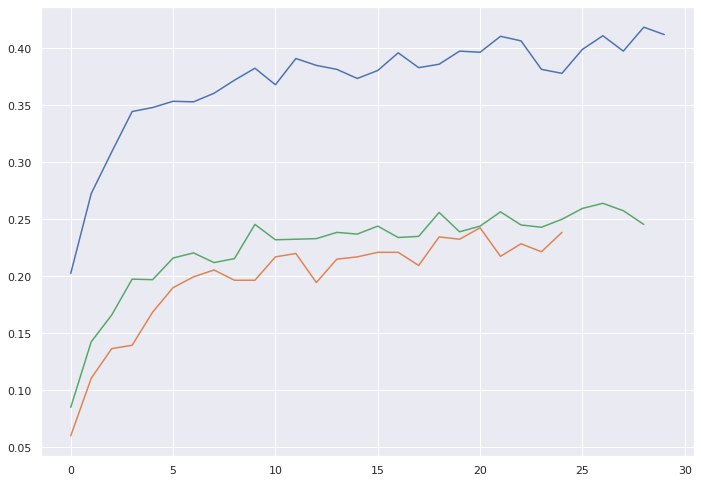

In [0]:
for m in models:
    epochs = np.arange(len(m.cluster_accs))
    plt.plot(epochs, m.cluster_accs)

#### Confusion Matrices

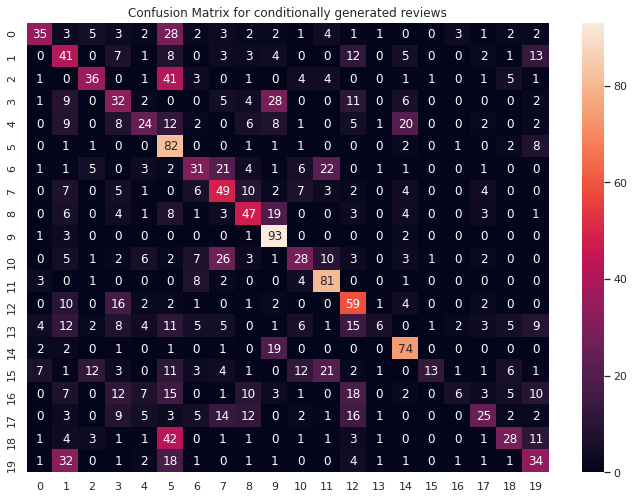

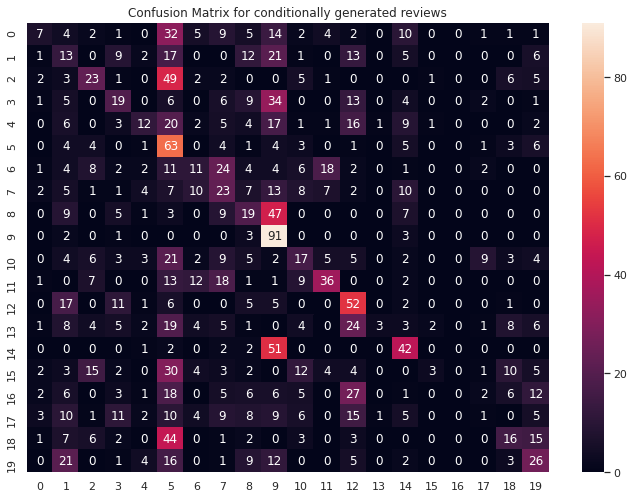

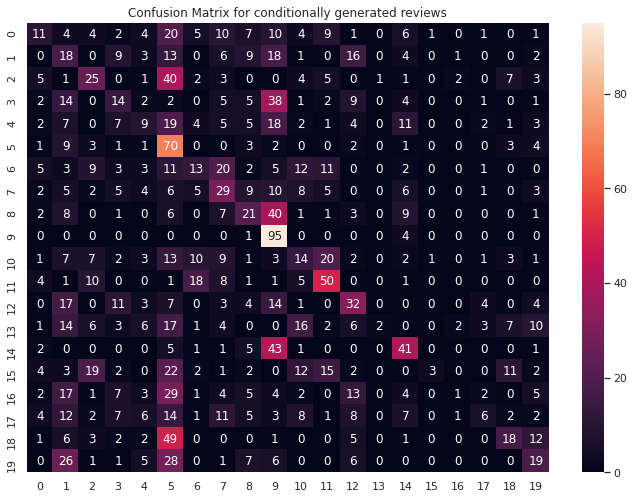

<Figure size 842.4x595.44 with 0 Axes>

In [0]:
clusterEval = ClusterEvaluation(utils)
for m in models:
    clusterEval.plot_conf(m.cluster_confs[-1])
    plt.figure()